In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [2]:
train_df = pd.read_csv('data/train_values.csv', index_col=0, parse_dates=['timestamp'])

/home/kiani/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:

test_df = pd.read_csv('data/test_values.csv', index_col=0, parse_dates=['timestamp'])

/home/kiani/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
label_df = pd.read_csv('data/train_labels.csv', index_col='process_id')


In [8]:
train_df = train_df.merge(label_df, right_index=True, left_on='process_id')

In [9]:
train_df.to_csv('data/full_data.csv')

In [74]:
def encode_categorical(df):
    # Currently just copy-pasted from http://drivendata.co/blog/rinse-over-run-benchmark/
    
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data (so useless feature)
    if 'pipeline_L12' in meta:
        meta.drop('pipeline_L12', axis=1)
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

# variables we'll use to create our time series features
ts_cols = [
    'process_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

# variables for binary time series features
bin_cols = [
    'supply_pump',
    'supply_pre_rinse',
    'supply_caustic',
    'return_caustic',
    'supply_acid',
    'return_acid',
    'supply_clean_water',
    'return_recovery_water',
    'return_drain',
    'object_low_level'
]

# phases, ordered from earliest to latest
phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid']


def encode_real_timeseries(df):   
    ts_df = df[ts_cols].set_index('process_id')
    
    # create features: count, min, max, mean, standard deviation
    ts_features = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std', 'count'])
    
    # Now we will get the mean + variance value of the last K measurements for each phase
    all_vals_per_phase = []
    K = 5
    col_names = ['process_id'] 
    for phase in phases:
        for col in ts_cols:
            col_names.extend(['mean_{}_{}_{}'.format(col, K, phase), 
                              'std_{}_{}_{}'.format(col, K, phase)])
    for process in tqdm_notebook(ts_features.index, total=len(ts_features)):
        vals_per_phase = [process]
        process_filtered_df = df[df['process_id'] == process]
        for phase in phases:
            filtered_df = process_filtered_df[process_filtered_df['phase'] == phase].tail(K)
            for col in ts_cols:
                vals_per_phase.extend([filtered_df[col].mean(), filtered_df[col].std()])
                
        all_vals_per_phase.append(vals_per_phase)
    values_df = pd.DataFrame(all_vals_per_phase, columns=col_names)
    values_df = values_df.set_index('process_id')
    
    ts_features = ts_features.merge(values_df, left_index=True, right_index=True)
    
    return ts_features

def encode_binary_timeseries(df):
    # TODO: Count fraction of True in each phase
    feature_vectors = []
    col_names = ['process_id'] 
    for phase in phases:
        for col in bin_cols:
            col_names.append('fraction_{}_{}'.format(col, phase))
            
    # Get fraction of True values for each binary timeseries
    for process in tqdm_notebook(set(df['process_id']), total=len(set(df['process_id']))):
        vector = [process]
        process_filtered_df = df[df['process_id'] == process]
        for phase in phases:
            filtered_df = process_filtered_df[process_filtered_df['phase'] == phase]
            for col in bin_cols:
                if len(filtered_df):
                    vector.append(sum(filtered_df[col]) / len(filtered_df))
                else:
                    vector.append(np.NaN)
                
        feature_vectors.append(vector)
                
    feature_df = pd.DataFrame(feature_vectors, columns=col_names)
    feature_df = feature_df.set_index('process_id')
    
    return feature_df

def create_feature_matrix(df):
    metadata = encode_categorical(df)
    time_series = encode_real_timeseries(df)
    binary_features = encode_binary_timeseries(df)
    
    # join metadata and time series features into a single dataframe
    feature_matrix = metadata
    feature_matrix = feature_matrix.merge(time_series, left_index=True, right_index=True)
    feature_matrix = feature_matrix.merge(binary_features, left_index=True, right_index=True)
    
    return feature_matrix

In [91]:
# try to mimic distributions in train and test set
train_values = train_df[train_df.phase != 'final_rinse']
fraction_per_phase = {
    'pre_rinse': 0.1,
    'caustic': 0.3,
    'intermediate_rinse': 0.3,
    'acid': 0.3
}

sampled_data = None

all_processes = set(train_values['process_id'])

for i in range(len(phases)):
    phase = phases[i]
    phase_values = train_values[train_values['phase'] == phase]
    phase_processes = set(phase_values['process_id'])
    
    # Now sample from the intersection of phase_processes and all_processes
    intersect = list(all_processes.intersection(phase_processes))
    sample = np.random.choice(intersect,
                              replace=False,
                              size=int(fraction_per_phase[phase] * len(all_processes)))
    
    # Remove the sampled processed from all_processes
    all_processes -= set(sample)
    
    # Now get all data records that correspond to the sampled process id's
    # up until the appropriate phase
    sample_df = train_values[(train_values['process_id'].isin(sample)) & 
                             (train_values['phase'].isin(phases[:i+1]))]
    
    if sampled_data is None:
        sampled_data = sample_df
    else:
        sampled_data = pd.concat([sampled_data, sample_df])
        
# Now add the remaining processes to the sampled_data
remaining_data = train_values[train_values['process_id'].isin(all_processes)]
sampled_data = pd.concat([sampled_data, remaining_data])

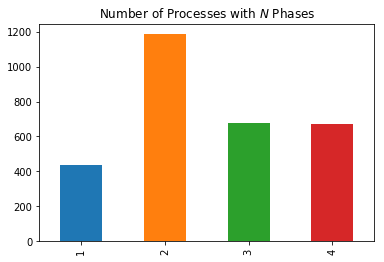

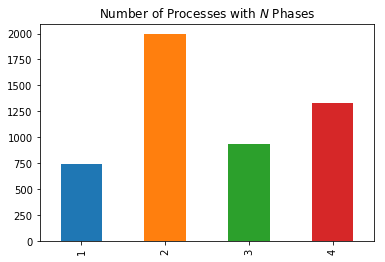

In [92]:
test_df.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Number of Processes with $N$ Phases");
plt.show()

sampled_data.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Number of Processes with $N$ Phases");
plt.show()

In [93]:
train_features = create_feature_matrix(sampled_data)
train_features.to_csv('data/train_features.csv')

In [94]:
print(train_features.shape)
train_features.head()

(5005, 255)


,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L12,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,...,fraction_supply_pump_acid,fraction_supply_pre_rinse_acid,fraction_supply_caustic_acid,fraction_return_caustic_acid,fraction_supply_acid_acid,fraction_return_acid_acid,fraction_supply_clean_water_acid,fraction_return_recovery_water_acid,fraction_return_drain_acid,fraction_object_low_level_acid
process_id,,,,,,,,,,,,,,,,,,,,,
20044,0,0,0,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20058,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20065,0,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20075,0,0,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20082,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
test_features = create_feature_matrix(test_df)
test_features.to_csv('data/test_features.csv')

In [79]:
print(test_features.shape)
test_features.head()

(2967, 255)


,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,pipeline_L9,...,fraction_supply_pump_acid,fraction_supply_pre_rinse_acid,fraction_supply_caustic_acid,fraction_return_caustic_acid,fraction_supply_acid_acid,fraction_return_acid_acid,fraction_supply_clean_water_acid,fraction_return_recovery_water_acid,fraction_return_drain_acid,fraction_object_low_level_acid
process_id,,,,,,,,,,,,,,,,,,,,,
20000,0,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20006,0,0,0,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20007,0,0,0,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20009,0,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20010,0,0,0,0,0,0,0,1,0,0,...,0.94636,0.0,0.0,0.390805,0.942529,0.590038,0.015326,0.019157,0.0,0.011494
